In [1]:
# Import necessary libraries
import os
import pywt
import sklearn
import numpy as np 
import pandas as pd 
import csv as csv_module
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import classification_report

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution1D, Flatten, Dense, Dropout, Softmax,MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [2]:
# Define relative path to the dataset
dataset_directory = 'D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0'

In [3]:
# Iterate through the files in the specified directory
for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\100.csv
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\100annotations.txt
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\101.csv
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\101annotations.txt
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\102.csv
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\102annotations.txt
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\103.csv
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\103annotations.txt
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\104.csv
D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0\104annotations.txt
D:/IIT_SE/Learning Resour

In [4]:
# Set the size of the plot figure to 10 inches in width and 6 inches in height
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
# Define the classes
classes = ['N', 'L', 'R', 'A', 'V']

# Count the number of classes
n_classes = len(classes)

# Initialize a list to store the count of each class
count_classes = [0] * n_classes

# Print the initialized count_classes list
print(count_classes)

[0, 0, 0, 0, 0]


In [6]:
# Define the path to the directory
path = 'D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0'

# Get the list of filenames in the directory
filenames = next(os.walk(path))[2]

# Initialize empty lists to store records and annotations
records = []
annotations = []

# Sort the filenames alphabetically
filenames.sort()

In [7]:
for f in filenames:
    # Split filename and file extension
    filename, file_extension = os.path.splitext(f)
    
    # Check if file extension is '.csv'
    if file_extension == '.csv':
        # Append to records list
        records.append(path + '/' + filename + file_extension)
    else:
        # Append to annotations list
        annotations.append(path + '/' + filename + file_extension)

# Print the first record in the records list
print(records[0])

D:/IIT_SE/Learning Resources/4th Year/FYP/Dataset/mit-bih-arrhythmia-database-1.0.0/100.csv


In [8]:
# Initialize an empty list to store the signal data
temp_signal = []

# Open the CSV file for reading
with open(records[6], 'r') as csvfile:
    # Create a CSV reader object
    csv_reader = csv_module.reader(csvfile, delimiter=',', quotechar='|')
    
    # Initialize a variable to track the row index
    row_index = -1
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Skip the header row
        if row_index >= 0:
            # Insert the signal data into the temp_signal list
            temp_signal.insert(row_index, int(row[1]))
        
        # Increment the row index
        row_index += 1

In [9]:
temp_signal[:10]

[962, 962, 962, 962, 962, 962, 962, 962, 966, 967]

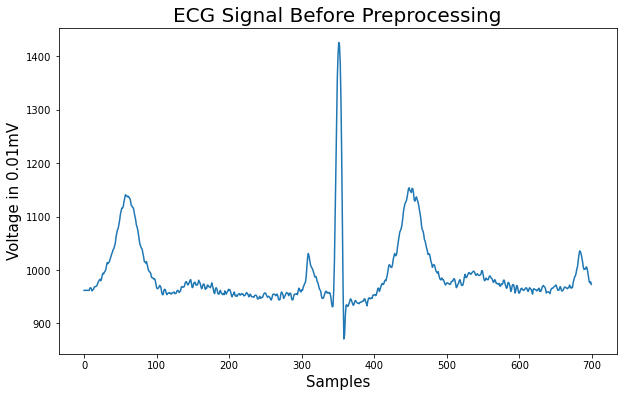

In [10]:
# Plot the ECG signal
plt.plot(temp_signal[:700])

# Set the title, x-axis label, and y-axis label
plt.title('ECG Signal Before Preprocessing', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage in 0.01mV', fontsize=15)

# Save the plot as an image file
plt.savefig('before_preprocessing')

# Display the plot
plt.show()

In [11]:
new_temp_signal=temp_signal

In [12]:
def denoise(input_data): 
    # Choose a wavelet for denoising
    wavelet = pywt.Wavelet('sym4')
    
    # Calculate the maximum level of decomposition
    max_levels = pywt.dwt_max_level(len(input_data), wavelet.dec_len)
    
    # Set the threshold for filtering
    threshold = 0.04  
    
    # Perform wavelet decomposition
    wavelet_coeffs = pywt.wavedec(input_data, 'sym4', level=max_levels)
    
    # Apply thresholding to wavelet coefficients
    for i in range(1, len(wavelet_coeffs)):
        wavelet_coeffs[i] = pywt.threshold(wavelet_coeffs[i], threshold * max(wavelet_coeffs[i]))
        
    # Reconstruct the denoised signal
    denoised_data = pywt.waverec(wavelet_coeffs, 'sym4')
    return denoised_data

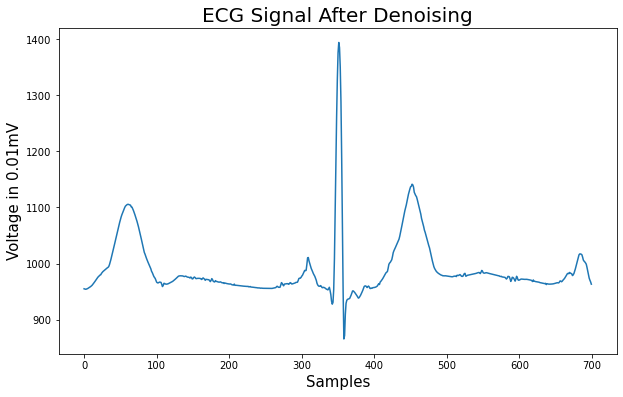

In [13]:
# Denoise the ECG signal
temp_signal=denoise(temp_signal)

# Plot the denoised ECG signal
plt.plot(temp_signal[:700])
plt.title('ECG Signal After Denoising',fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage in 0.01mV', fontsize=15)

# Save the plot as an image file
plt.savefig('after_denoising')

# Display the plot
plt.show()

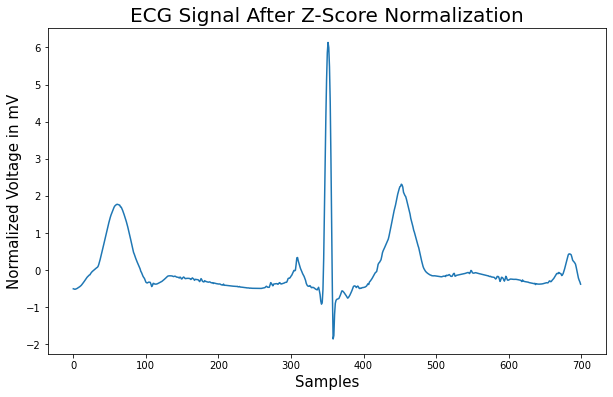

In [14]:
# Perform Z-score normalization on the ECG signal
temp_signal = stats.zscore(temp_signal)

# Plot the normalized ECG signal
plt.plot(temp_signal[:700])

# Set the title, x-axis label, and y-axis label
plt.title('ECG Signal After Z-Score Normalization', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Normalized Voltage in mV', fontsize=15)

# Save the plot as an image file
plt.savefig('after_normalization')

# Display the plot
plt.show()

In [15]:
# Initialize lists to store features (X) and labels (y)
features = []
labels = []

window_size = 180

# Iterate over each record
for record_index in range(len(records)):
    signals = []

    # Read ECG signals from the record file
    with open(records[record_index], 'r') as csvfile:
        spamreader = csv_module.reader(csvfile, delimiter=',', quotechar='|')
        row_index = -1
        for row in spamreader:
            if row_index >= 0:
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Denoise the ECG signals
    signals = denoise(signals)
    
    # Perform Z-score normalization
    signals = stats.zscore(signals)

    # Read annotations from the corresponding annotation file
    with open(annotations[record_index], 'r') as fileID:
        data = fileID.readlines()
        beat = []

        # Iterate over each annotation
        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)

            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                
                # Extract beat data within the window size
                if window_size <= pos and pos < (len(signals) - window_size):
                    beat = signals[pos - window_size:pos + window_size]

                    # Append features and labels
                    features.append(beat)
                    labels.append(arrhythmia_index)

# Print the shape of features and labels
print(np.shape(features), np.shape(labels))

(100012, 360) (100012,)


In [16]:
count_classes

[75052, 8075, 7259, 2546, 7130]

0    75011
1     8071
2     7255
4     7129
3     2546
Name: 0, dtype: int64


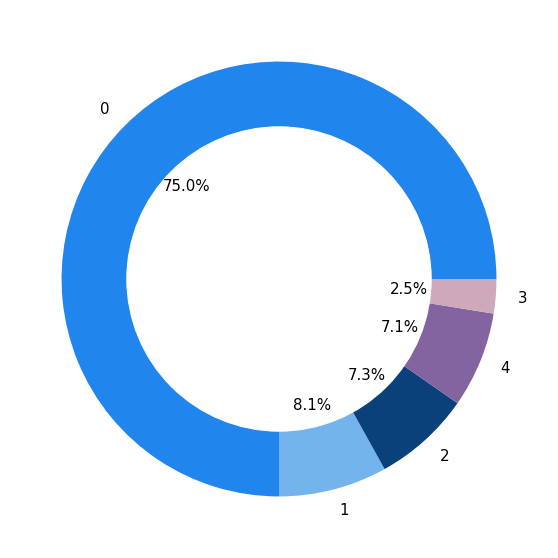

In [17]:
# Create a DataFrame for the labels (y)
labels_df = pd.DataFrame(labels)

# Display the first few rows of the DataFrame
labels_df.head()

# Count the occurrences of each class
per_class = labels_df[labels_df.shape[1] - 1].value_counts()

# Print the counts per class
print(per_class)

#Create a pie chart to visualize the class distribution
plt.figure(figsize=(30, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')

# Provide labels dynamically based on per_class keys
plt.pie(per_class, labels=per_class.index, colors=['#2085ec', '#72b4eb', '#0a417a', '#8464a0', '#cea9bc'], autopct='%1.1f%%', textprops={'fontsize': 15})
p = plt.gcf()
p.gca().add_artist(my_circle)

# Display the pie chart
plt.show()

# Save the pie chart as an image file
p.savefig('before_piechart.png')

In [18]:
# Convert the list of features (X) to a NumPy array
features_array = np.array(features)

# Reshape the features array to have 360 columns
reshaped_features = features_array.reshape(-1, 360)

# Print the shape of the reshaped features
print(reshaped_features.shape)

(100012, 360)


In [19]:
# Convert the reshaped features array to a DataFrame
features_df = pd.DataFrame(reshaped_features)

# Display the first few rows of the DataFrame
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.014193,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140757,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,-0.005353,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.014056,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.024847,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073


In [20]:
# Concatenate features (X) and labels (y) DataFrames along the columns
combined_df = pd.concat([features_df, labels_df], axis=1)

# Display the first few rows of the combined DataFrame
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,0
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095,0
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478,0
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259,0
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388,0
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073,0


In [21]:
# Generate a list of column labels ranging from 0 to 360
column_labels = list(range(361))

# Set the column labels of the DataFrame
combined_df.columns = column_labels

# Display the DataFrame with new column labels
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095,0
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478,0
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259,0
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388,0
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073,0


In [22]:
# Extract the dataframe for each class
df_0 = combined_df[combined_df[combined_df.columns[-1]] == 0].sample(n=10000, random_state=42)
df_1 = combined_df[combined_df[combined_df.columns[-1]] == 1]
df_2 = combined_df[combined_df[combined_df.columns[-1]] == 2]
df_3 = combined_df[combined_df[combined_df.columns[-1]] == 3]
df_4 = combined_df[combined_df[combined_df.columns[-1]] == 4]

# Upsample the minority classes
df_1_upsampled = resample(df_1, replace=True, n_samples=7000, random_state=122)
df_2_upsampled = resample(df_2, replace=True, n_samples=7000, random_state=123)
df_3_upsampled = resample(df_3, replace=True, n_samples=5000, random_state=125)
df_4_upsampled = resample(df_4, replace=True, n_samples=7000, random_state=125)

# Concatenate the upsampled dataframes with the majority class dataframe
combined_df = pd.concat([df_0, df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled])


0    10000
1     7000
2     7000
4     7000
3     5000
Name: 360, dtype: int64


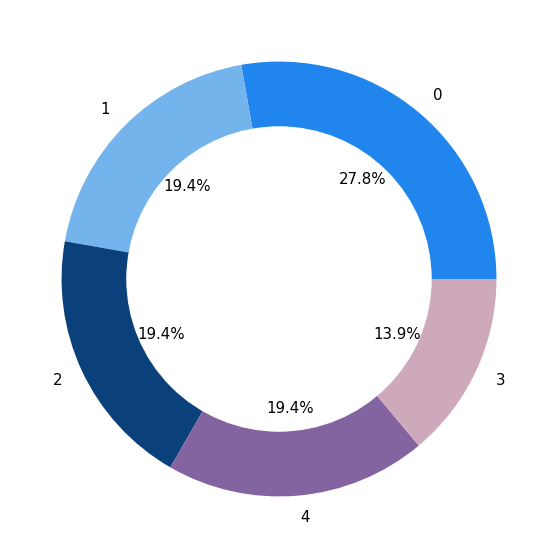

In [23]:
# Count the occurrences of each class
per_class = combined_df[combined_df.columns[-1]].value_counts()

# Print the counts per class
print(per_class)

#Create a pie chart to visualize the class distribution
plt.figure(figsize=(30, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')

# Provide labels dynamically based on per_class keys
plt.pie(per_class, labels=per_class.index, colors=['#2085ec', '#72b4eb', '#0a417a', '#8464a0', '#cea9bc'], autopct='%1.1f%%', textprops={'fontsize': 15})
p = plt.gcf()
p.gca().add_artist(my_circle)

# Display the pie chart
plt.show()

# Save the pie chart as an image file
p.savefig('after_piechart.png')

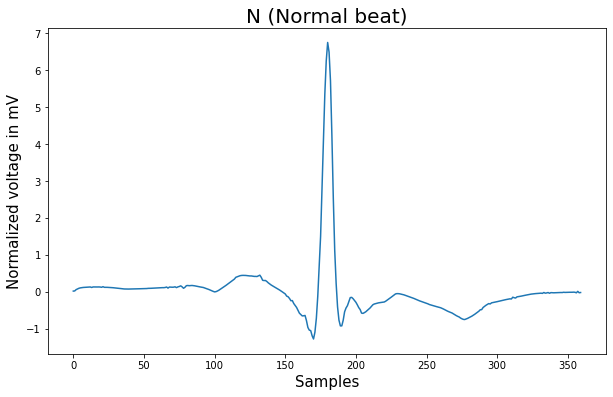

In [24]:
# Find the index of the first sample with label 0 (N)
i = 0
while labels[i] != 0:
    i += 1

# Plot the ECG signal for class N
plt.plot(features[i])
plt.title('N (Normal beat)', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Normalized voltage in mV', fontsize=15)
plt.savefig('N')

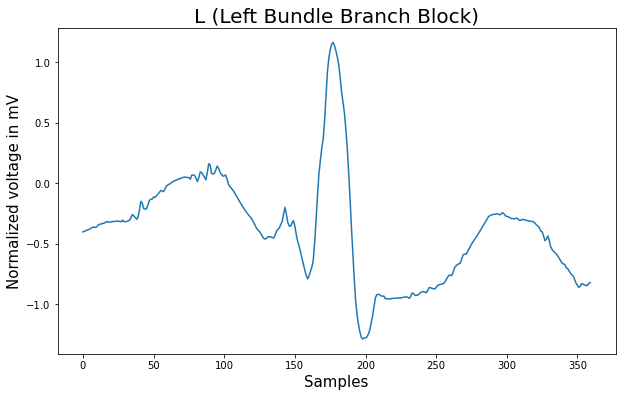

In [25]:
# Find the index of the first sample with label 1 (L)
i = 0
while labels[i] != 1:
    i += 1

# Plot the ECG signal for class L
plt.plot(features[i])
plt.title('L (Left Bundle Branch Block)', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Normalized voltage in mV', fontsize=15)
plt.savefig('L')

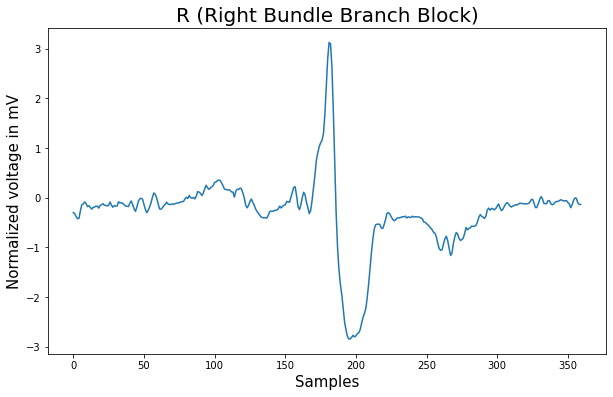

In [26]:
# Find the index of the first sample with label 2 (R)
i = 0
while labels[i] != 2:
    i += 1

# Plot the ECG signal for class R
plt.plot(features[i])
plt.title('R (Right Bundle Branch Block)', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Normalized voltage in mV', fontsize=15)
plt.savefig('R')

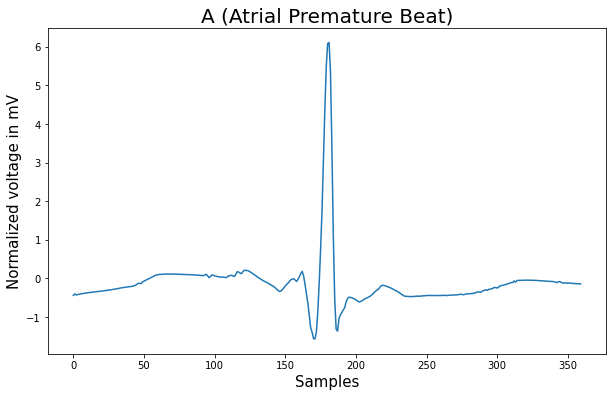

In [27]:
# Find the index of the first sample with label 3 (A)
i = 0
while labels[i] != 3:
    i += 1

# Plot the ECG signal for class A
plt.plot(features[i])
plt.title('A (Atrial Premature Beat)', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Normalized voltage in mV', fontsize=15)
plt.savefig('A')

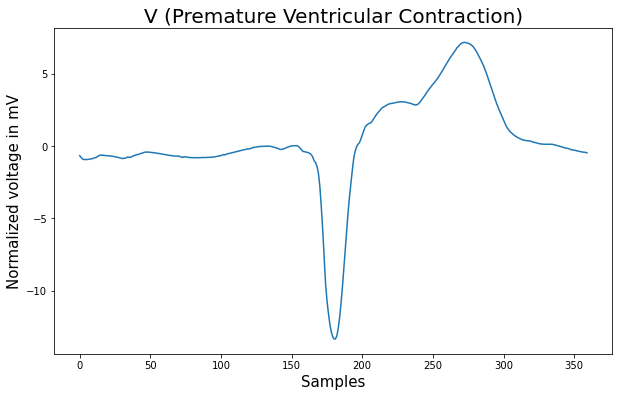

In [28]:
# Find the index of the first sample with label 4 (V)
i = 0
while labels[i] != 4:
    i += 1

# Plot the ECG signal for class V
plt.plot(features[i])
plt.title('V (Premature Ventricular Contraction)', fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Normalized voltage in mV', fontsize=15)
plt.savefig('V')

In [29]:
# Split the combined DataFrame into training and testing sets
train_data, test_data = train_test_split(combined_df, test_size=0.20, random_state=7)

# Display the shapes of the training and testing sets
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (28800, 361)
Testing data shape: (7200, 361)


In [34]:
# Extract the target labels from the training and testing sets
target_train = train_data[train_data.columns[-1]]
target_test = test_data[test_data.columns[-1]]

# Create Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_reshaped[:, :, 0], target_train)

# Evaluate the Random Forest model
rf_accuracy = rf_model.score(X_test_reshaped[:, :, 0], target_test)

# Print the Random Forest accuracy
print('Random Forest Accuracy:', rf_accuracy)

Random Forest Accuracy: 0.9855555555555555


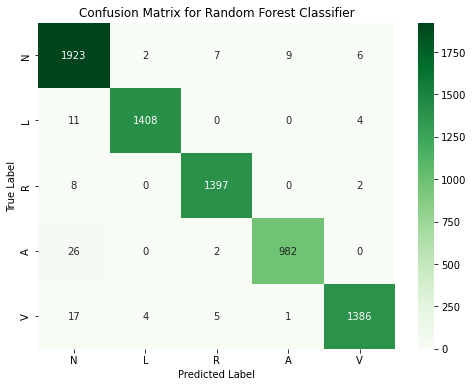

In [37]:
# Create empty lists for true labels and predictions
true_labels = []
predictions = rf_model.predict(X_test_reshaped[:, :, 0])

# Populate true labels list with each element in target_test
for element in target_test:
    true_labels.append(element)

# Calculate confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes)
plt.savefig('confusion_matrix_rf.png')
plt.show()

In [38]:
# Generate classification report
classification_rep = classification_report(true_labels, predictions, target_names=classes, digits=4)

# Print classification report
print(classification_rep)

              precision    recall  f1-score   support

           N     0.9688    0.9877    0.9781      1947
           L     0.9958    0.9895    0.9926      1423
           R     0.9901    0.9929    0.9915      1407
           A     0.9899    0.9723    0.9810      1010
           V     0.9914    0.9809    0.9861      1413

    accuracy                         0.9856      7200
   macro avg     0.9872    0.9846    0.9859      7200
weighted avg     0.9857    0.9856    0.9856      7200

